In [1]:
# Import packages
import pandas as pd
import pickle
import numpy as np

# Import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# Sklearn
from sklearn.decomposition import PCA

%matplotlib inline
%config InlineBackend.figure_format="retina"

In [2]:
# Load pickle data - cleaned data
with open("processed_data.pkl", "rb") as f:
    data = pickle.load(f)
f.close()

In [3]:
data.shape

(2937990, 142)

In [4]:
# Check records with full NOVA grade and nutri-score data
data2 = data[data["nova_group"] != ""]

In [5]:
data2.shape

(783256, 142)

In [6]:
# Data with complete NOVA and nutriscore data
full = data2[data2["nutriscore_grade"] != ""]
full.shape

(577084, 142)

### Initial EDA

In [8]:
# Size of the full dataset
full.shape

(577084, 142)

In [9]:
# Top 15 countries composition
pct = full["countries_en"].value_counts()[0:15].sum() / full.shape[0]
print(f"Percentage of data from top 15 countries: {pct:.2%}")

Percentage of data from top 15 countries: 89.20%


Food products from top 15 countries (including combination of countries) listed constitute about 90% of the data. We will use data from top 15 countries

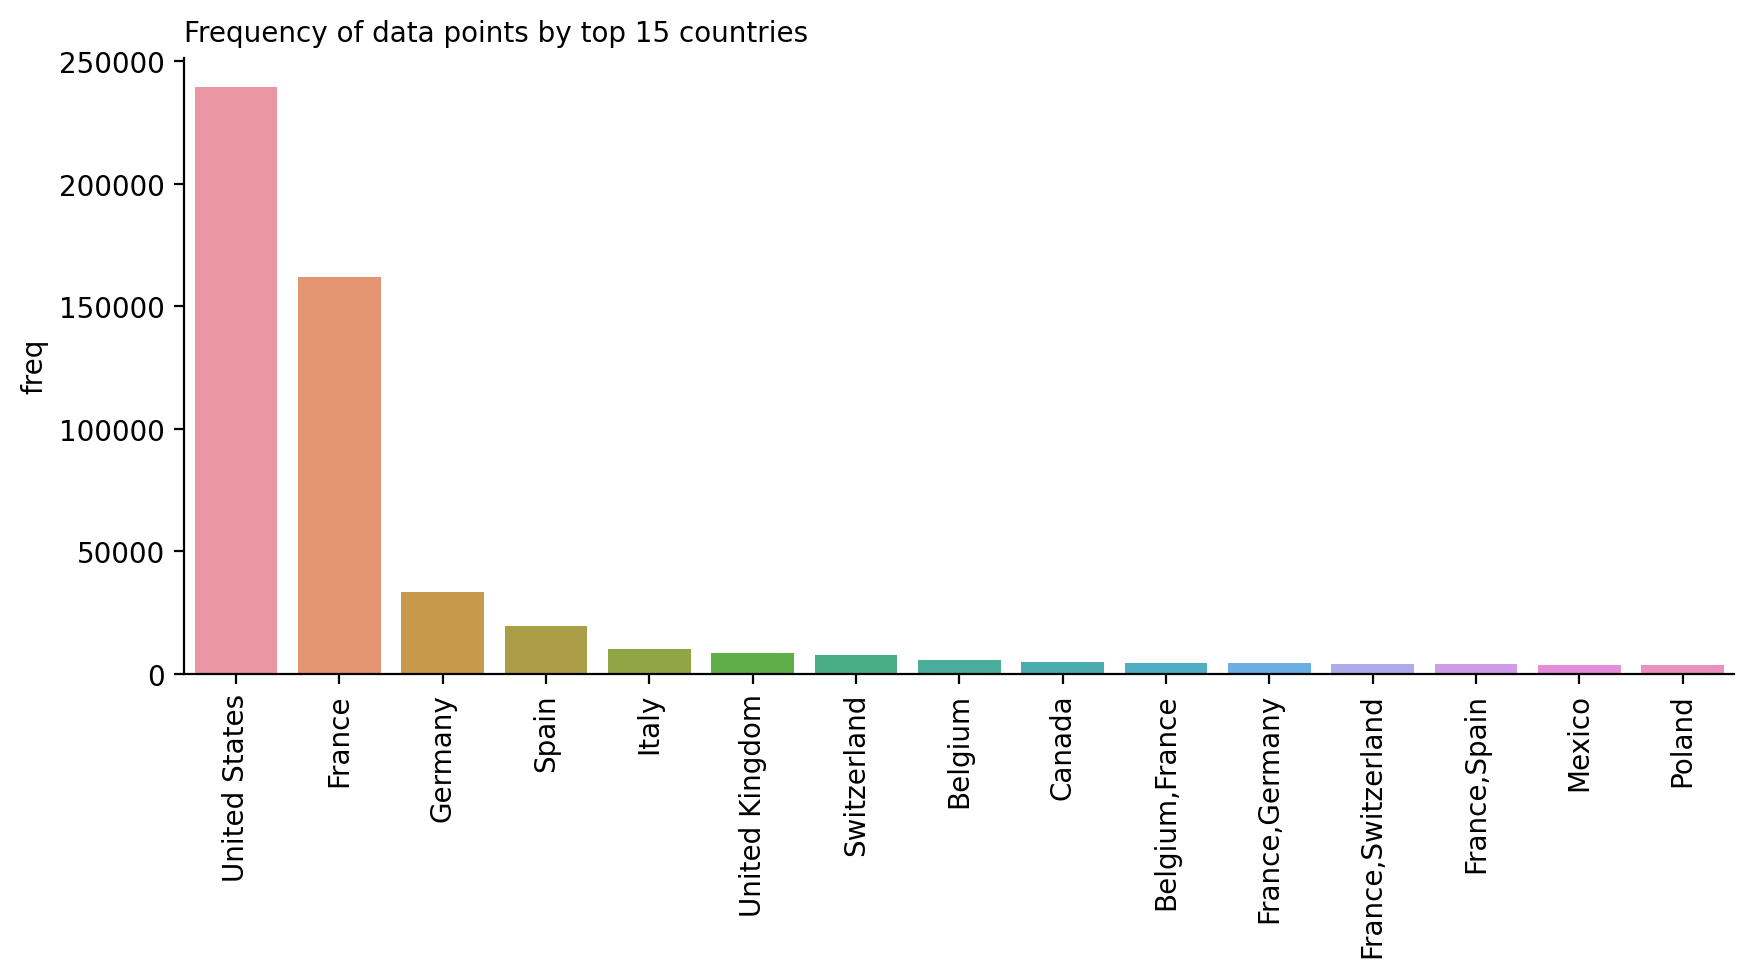

In [10]:
# Visualize the countries
country_viz = pd.DataFrame(full["countries_en"].value_counts()[0:15].index.values, columns=["countries"])
countries = pd.DataFrame(list(full["countries_en"].value_counts()[0:15]), columns=["freq"])
country_viz = pd.concat([country_viz, countries], axis=1)
country_viz["log_freq"] = np.log(country_viz["freq"])

plt.figure(figsize=(10, 4))
sns.barplot(data=country_viz, x="countries", y="freq")
plt.title("Frequency of data points by top 15 countries", loc="left", fontsize=10)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.xlabel("")
plt.tick_params(axis="x", rotation=90)
plt.show()

In [11]:
# Visualize the distribution of NOVA grade
nova_color = ["#04A902", "#FFCC01", "#FF6600", "#FF0000"]
country_idx = full["countries_en"].value_counts()[0:15].index.values
nova = full[full["countries_en"].isin(country_idx)]

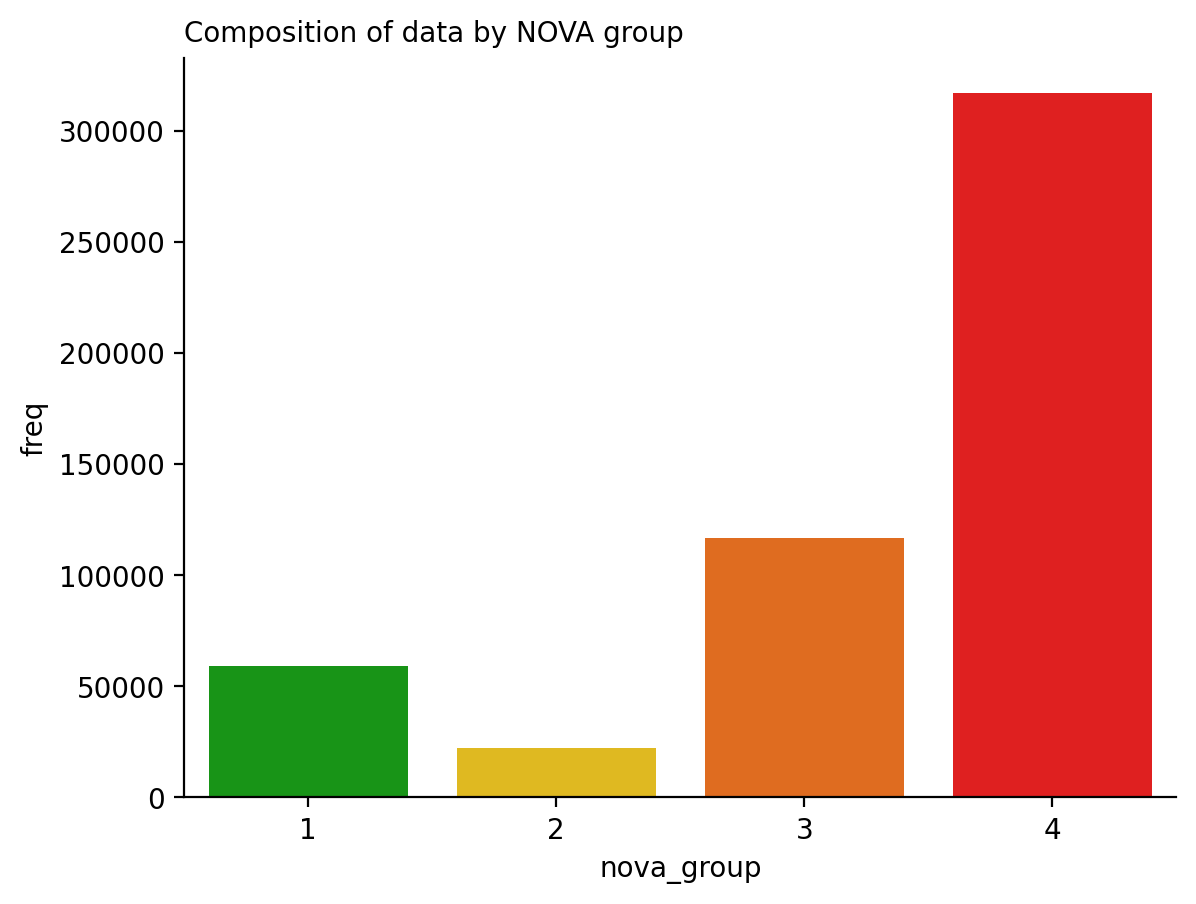

In [12]:
nova_viz = nova["nova_group"].value_counts().sort_index().values
nova_viz = pd.DataFrame(nova_viz, columns=["freq"])
nova_viz = pd.concat([pd.DataFrame(["1", "2", "3", "4"], columns=["nova_group"]), nova_viz], axis=1)

sns.barplot(data=nova_viz, x="nova_group", y="freq", palette=nova_color)
plt.title("Composition of data by NOVA group", loc="left", fontsize=10)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.show()

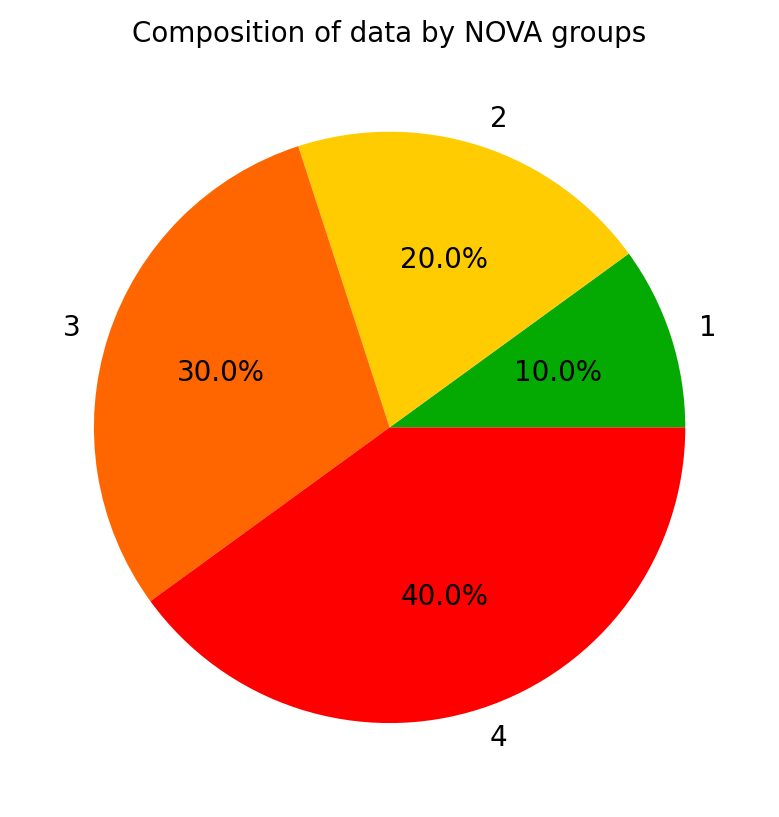

In [13]:
plt.pie(data=nova_viz, x="nova_group", labels=["1", "2", "3", "4"], autopct="%1.1f%%", textprops={"fontsize": 10}, colors=nova_color)
plt.title("Composition of data by NOVA groups", fontsize=10)
plt.show()

As the NOVA group will be the target variable, there is imbalance of labels in the data. We will need to down sample the dataset later to make the NOVA groups' distribution consistent

In [14]:
# Visualize the distribution of Nutriscore group
nutriscore_color = ["#028141", "#85BB2F", "#FECB03", "#EE8100", "#E63D11"]
country_idx = full["countries_en"].value_counts()[0:15].index.values
nutriscore_grade = full[full["countries_en"].isin(country_idx)]

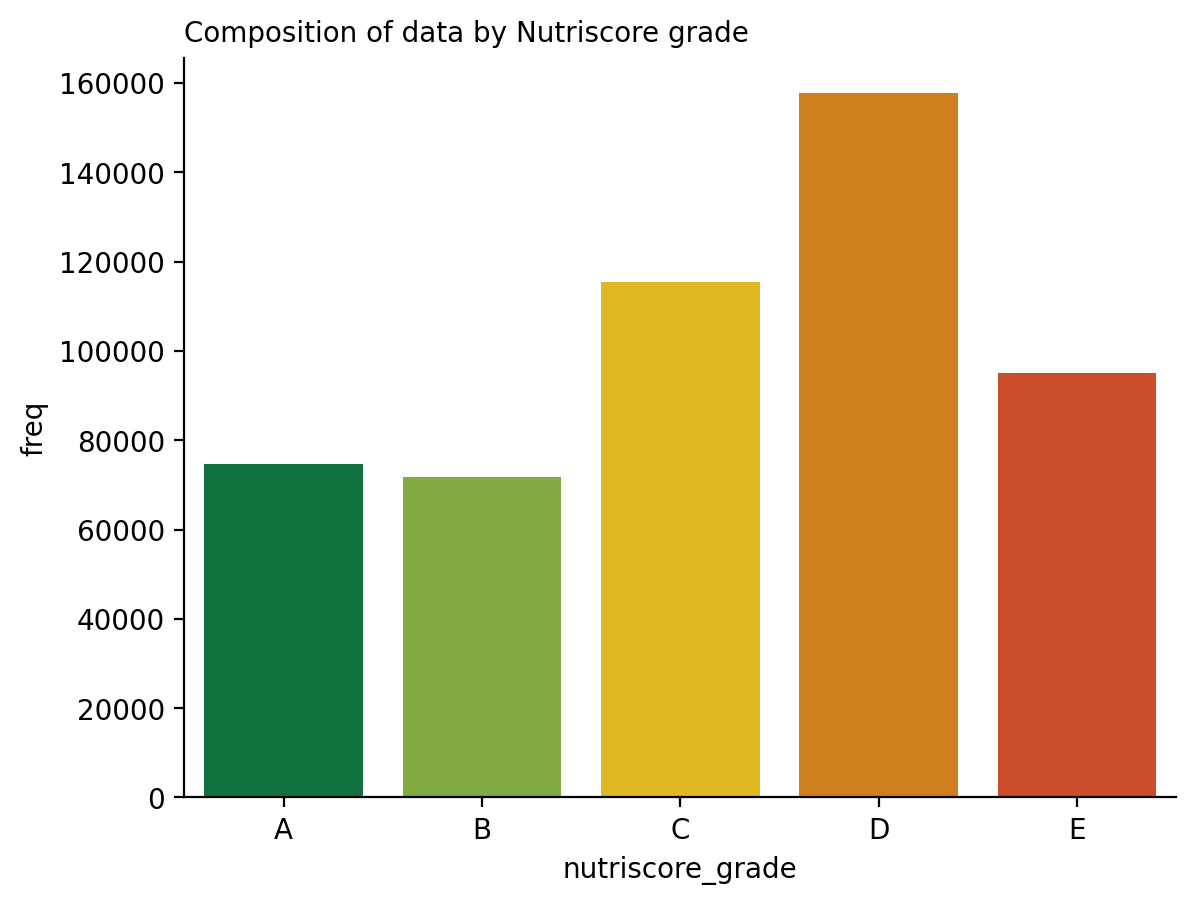

In [15]:
nutriscore_grade_viz = nutriscore_grade["nutriscore_grade"].value_counts().sort_index().values
nutriscore_grade_viz = pd.DataFrame(nutriscore_grade_viz, columns=["freq"])
nutriscore_grade_viz = pd.concat([pd.DataFrame(["A", "B", "C", "D", "E"], columns=["nutriscore_grade"]), nutriscore_grade_viz], axis=1)

sns.barplot(data=nutriscore_grade_viz, x="nutriscore_grade", y="freq", palette=nutriscore_color)
plt.title("Composition of data by Nutriscore grade", loc="left", fontsize=10)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.show()

In [16]:
# Visualize the distribution of Nutriscore score
country_idx = full["countries_en"].value_counts()[0:15].index.values
nutriscore_score = full[full["countries_en"].isin(country_idx)]

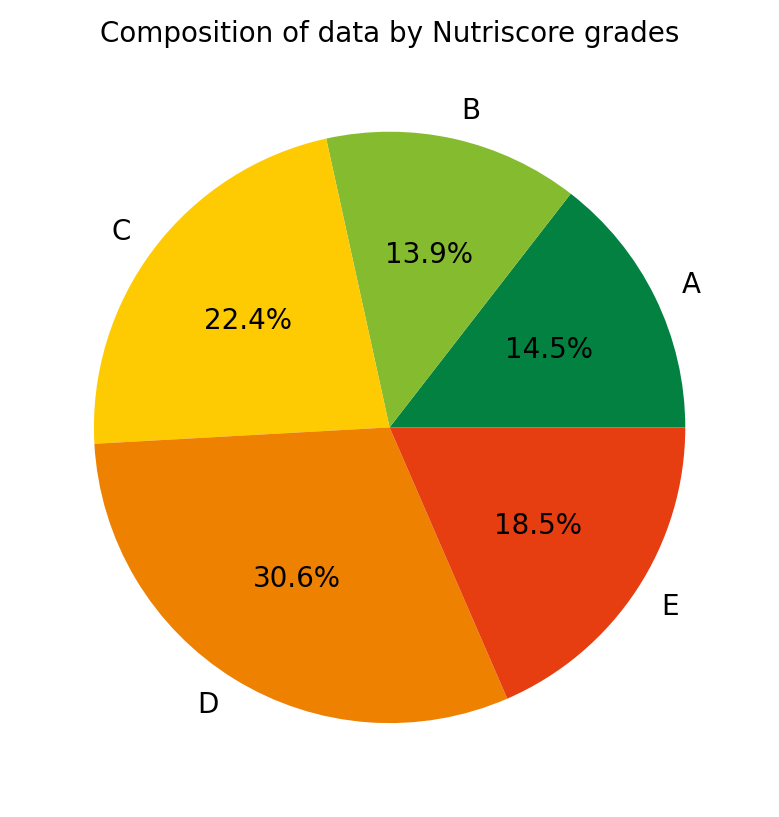

In [17]:
plt.pie(x=nutriscore_grade_viz["freq"], labels=["A", "B", "C", "D", "E"], autopct="%1.1f%%", textprops={"fontsize": 10}, colors=nutriscore_color)
plt.title("Composition of data by Nutriscore grades", fontsize=10)
plt.show()

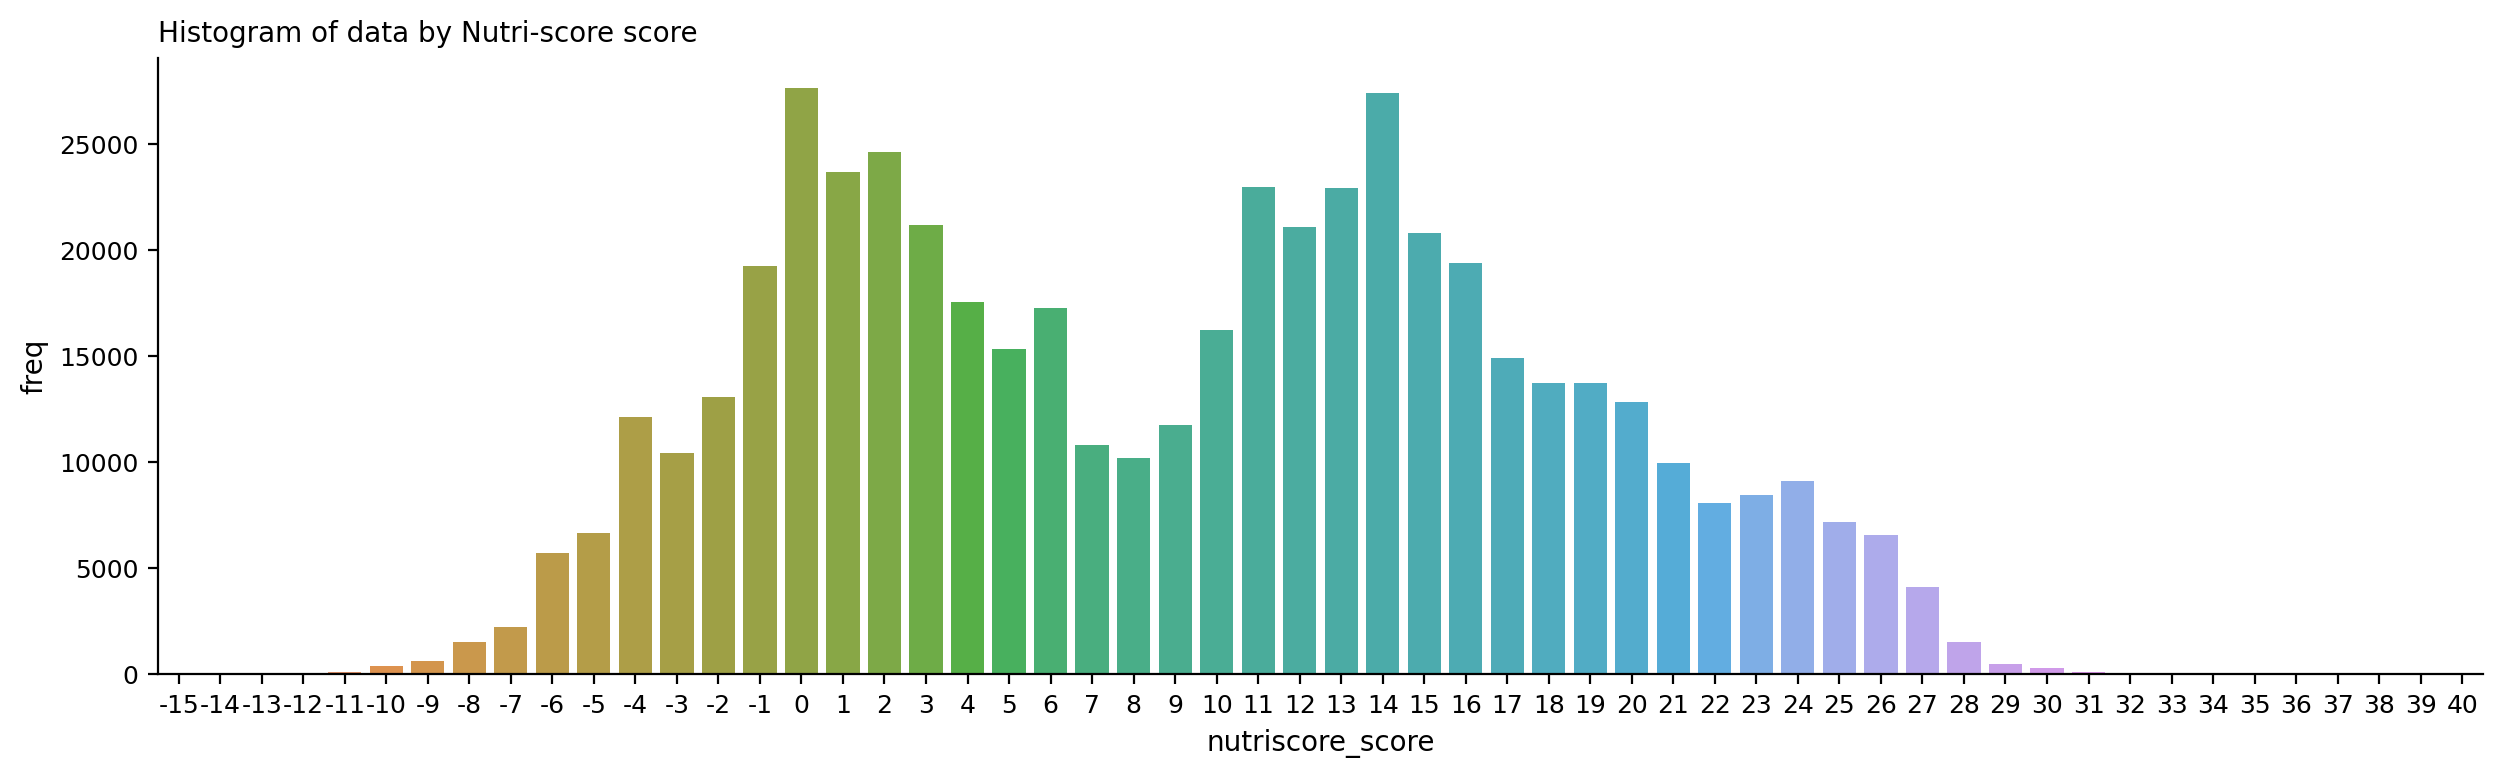

In [18]:
nutriscore_score_viz = nutriscore_score["nutriscore_score"].value_counts().sort_index()
nutriscore_score_viz = pd.DataFrame(nutriscore_score_viz).reset_index()
nutriscore_score_viz.rename(columns={"nutriscore_score": "freq", "index": "nutriscore_score"}, inplace=True)
nutriscore_score_viz["nutriscore_score"] = pd.to_numeric(nutriscore_score_viz["nutriscore_score"])
nutriscore_score_viz.sort_values("nutriscore_score", inplace=True)

plt.figure(figsize=(15, 4))
sns.barplot(data=nutriscore_score_viz, x="nutriscore_score", y="freq")
plt.tick_params(axis="both", labelsize=9)
plt.title("Histogram of data by Nutri-score score", loc="left", fontsize=10)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.show()

In [25]:
# Top 5 country and their NOVA grade compositions
country_idx = full["countries_en"].value_counts()[0:5].index.values
country_nova = full[full["countries_en"].isin(country_idx)]

In [26]:
country_nova = pd.pivot_table(country_nova, index=["nova_group"], columns=["countries_en"], values="created_datetime", aggfunc="count").reset_index()

In [28]:
country_nova = country_nova.T.reset_index().iloc[1:, :]
country_nova.columns = ["country", "1", "2", "3", "4"]

# Melt the dataframe for side by side bar plot
country_nova_melt = country_nova.melt(id_vars="country", value_name="freq", var_name="nova_group")
country_nova_melt["log_freq"] = country_nova_melt.apply(lambda x: np.log(x["freq"]), axis=1)

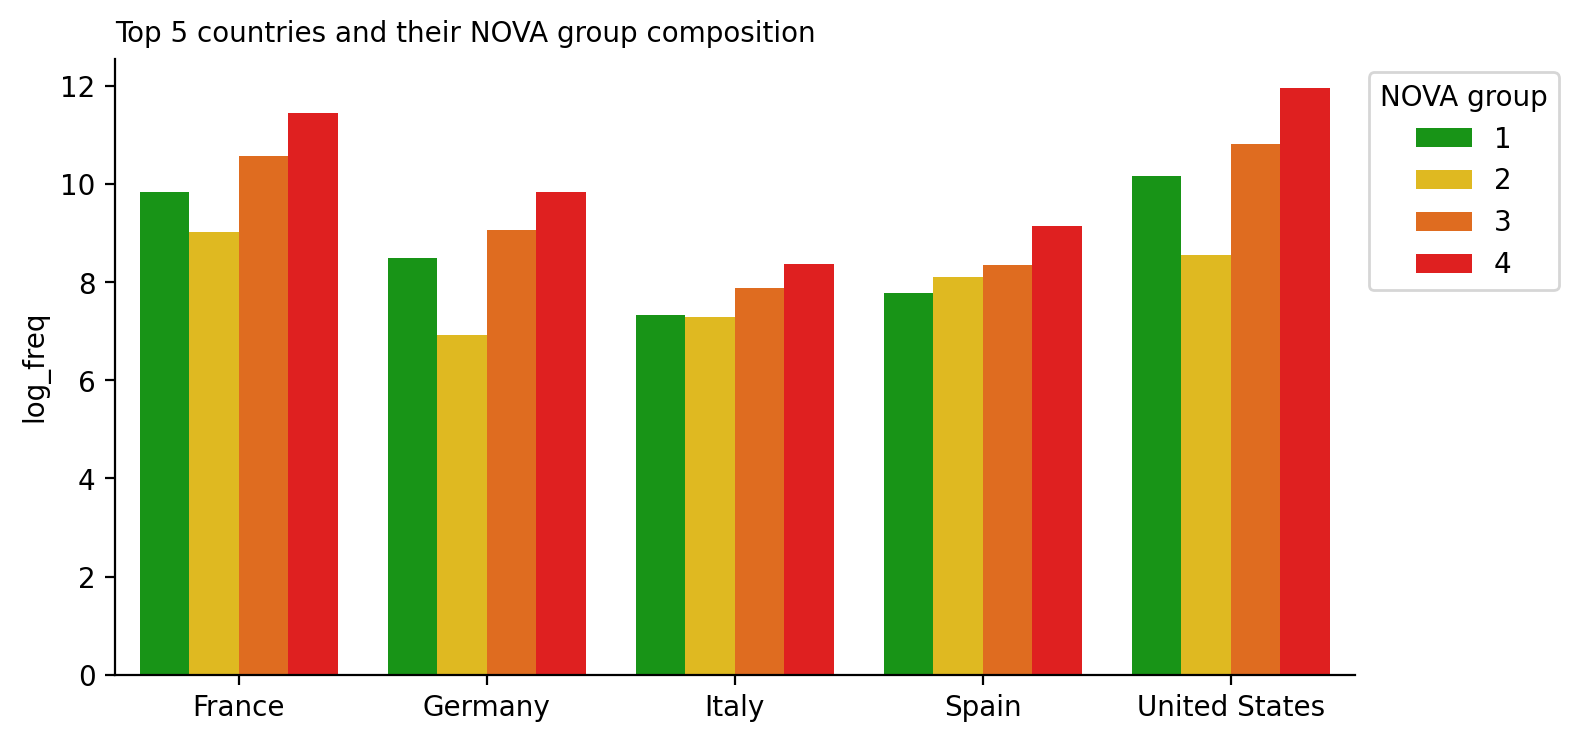

In [29]:
# Visualize the top 5 countries by NOVA bucket compositions
plt.figure(figsize=(8, 4))
sns.barplot(data=country_nova_melt, x="country", y="log_freq", hue="nova_group", palette=nova_color)
plt.legend(title="NOVA group", fontsize=10, bbox_to_anchor=(1,1))
plt.title("Top 5 countries and their NOVA group composition", loc="left", fontsize=10)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.xlabel("")
plt.show()

In [30]:
# Top 5 country and their NOVA grade composition by %
country_idx = full["countries_en"].value_counts()[0:5].index.values
country_nova_pc = full[full["countries_en"].isin(country_idx)]

In [31]:
country_nova_pc = pd.pivot_table(country_nova_pc, index=["nova_group"], columns=["countries_en"], values="created_datetime", aggfunc="count").reset_index()

In [32]:
for country in ["France", "Germany", "Italy", "Spain", "United States"]:
    country_nova_pc[country] = country_nova_pc[country] / country_nova_pc[country].sum() * 100

In [33]:
country_nova_pc = country_nova_pc.T.reset_index().iloc[1:, :]
country_nova_pc.columns = ["country", "1", "2", "3", "4"]

# Melt the dataframe for side by side bar plot
country_nova_pc_melt = country_nova_pc.melt(id_vars="country", value_name="freq", var_name="nova_group")

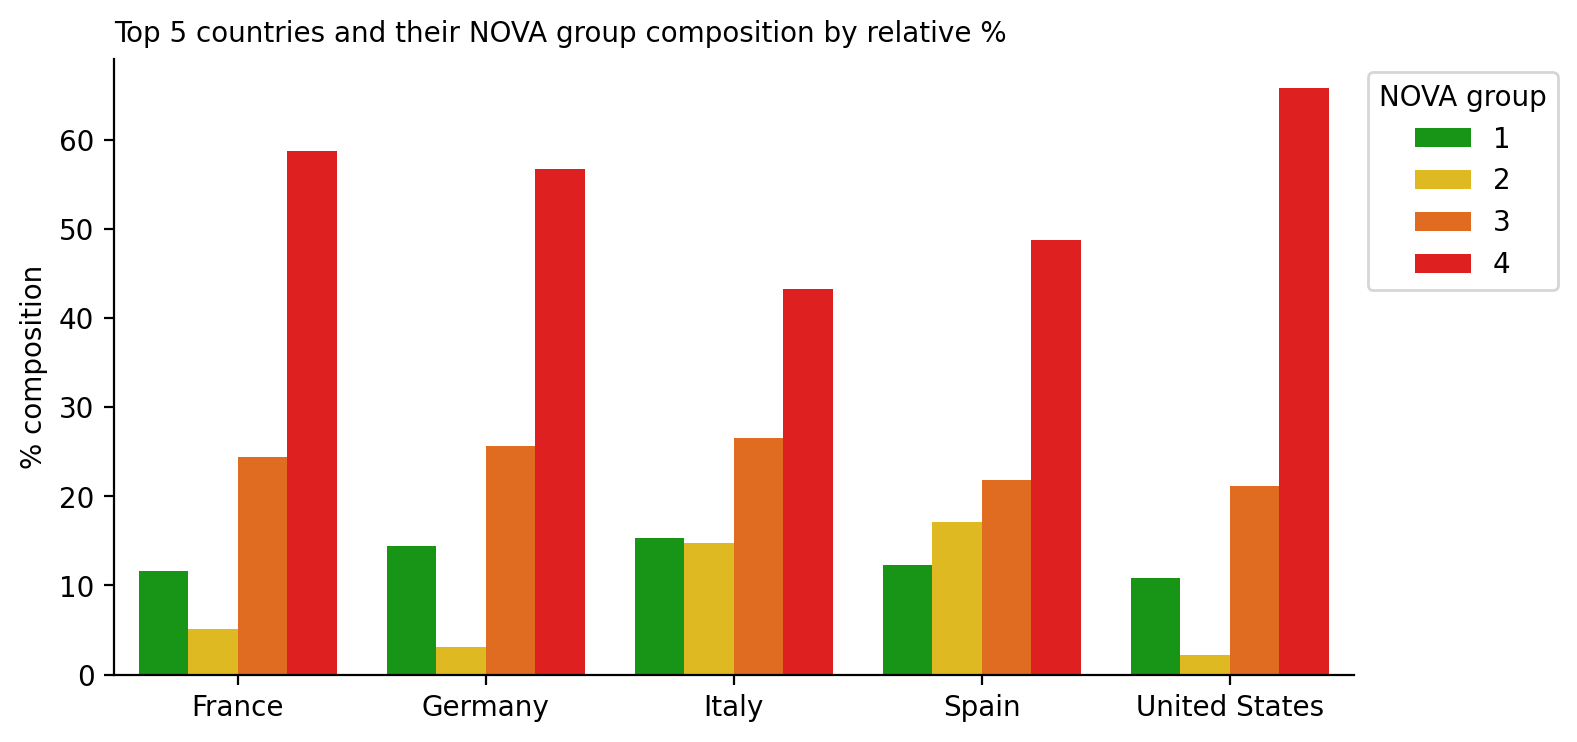

In [34]:
# Visualize the top 5 countries by NOVA bucket composition in %
plt.figure(figsize=(8, 4))
sns.barplot(data=country_nova_pc_melt, x="country", y="freq", hue="nova_group", palette=nova_color)
plt.legend(title="NOVA group", fontsize=10, bbox_to_anchor=(1,1))
plt.title("Top 5 countries and their NOVA group composition by relative %", loc="left", fontsize=10)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.xlabel("")
plt.ylabel("% composition")
plt.show()

In [35]:
# Top 5 country and their Nutriscore grade compositions
country_idx = full["countries_en"].value_counts()[0:5].index.values
country_nutri = full[full["countries_en"].isin(country_idx)]

In [36]:
country_nutri = pd.pivot_table(country_nutri, index=["nutriscore_grade"], columns=["countries_en"], values="created_datetime", aggfunc="count").reset_index()
country_nutri["nutriscore_grade"] = country_nutri["nutriscore_grade"].apply(lambda x: x.upper())

In [37]:
country_nutri = country_nutri.T.reset_index().iloc[1:, :]
country_nutri.columns = ["country", "A", "B", "C", "D", "E"]

# Melt the dataframe for side by side bar plot
country_nutri_melt = country_nutri.melt(id_vars="country", value_name="freq", var_name="nutriscore_grade")
country_nutri_melt["log_freq"] = country_nutri_melt.apply(lambda x: np.log(x["freq"]), axis=1)

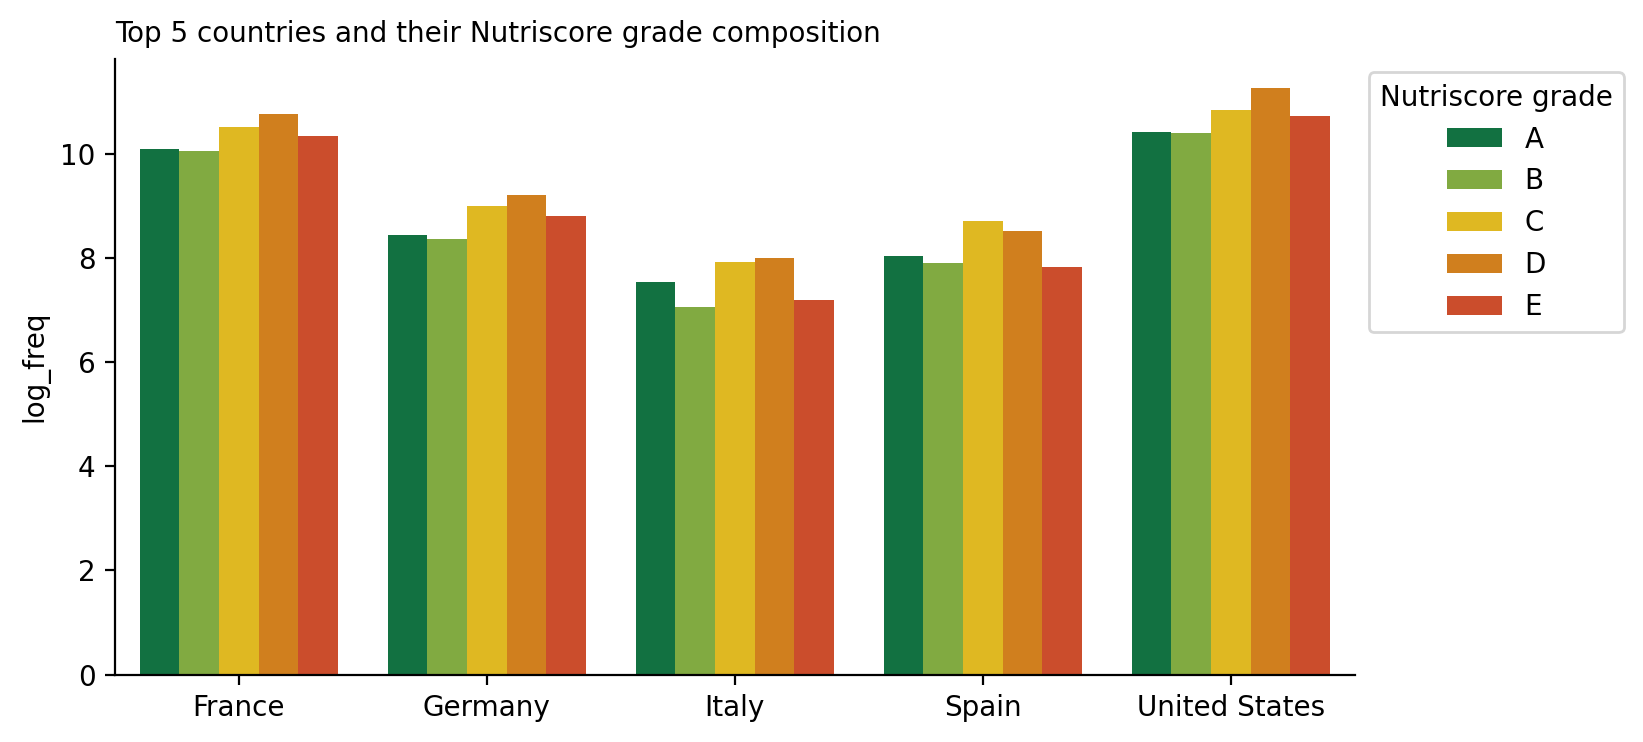

In [38]:
# Visualize the top 5 countries by Nutriscore grade compositions
plt.figure(figsize=(8, 4))
sns.barplot(data=country_nutri_melt, x="country", y="log_freq", hue="nutriscore_grade", palette=nutriscore_color)
plt.legend(title="Nutriscore grade", fontsize=10, bbox_to_anchor=(1,1))
plt.title("Top 5 countries and their Nutriscore grade composition", loc="left", fontsize=10)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.xlabel("")
plt.show()

In [39]:
# Top 5 country and their Nutriscore grade compositions by relative %
country_idx = full["countries_en"].value_counts()[0:5].index.values
country_nutri_pc = full[full["countries_en"].isin(country_idx)]

In [40]:
country_nutri_pc = pd.pivot_table(country_nutri_pc, index=["nutriscore_grade"], columns=["countries_en"], values="created_datetime", aggfunc="count").reset_index()

In [41]:
for country in ["France", "Germany", "Italy", "Spain", "United States"]:
    country_nutri_pc[country] = country_nutri_pc[country] / country_nutri_pc[country].sum() * 100

In [42]:
country_nutri_pc = country_nutri_pc.T.reset_index().iloc[1:, :]
country_nutri_pc.columns = ["country", "A", "B", "C", "D", "E"]

# Melt the dataframe for side by side bar plot
country_nutri_pc_melt = country_nutri_pc.melt(id_vars="country", var_name="nutriscore_grade", value_name="freq")

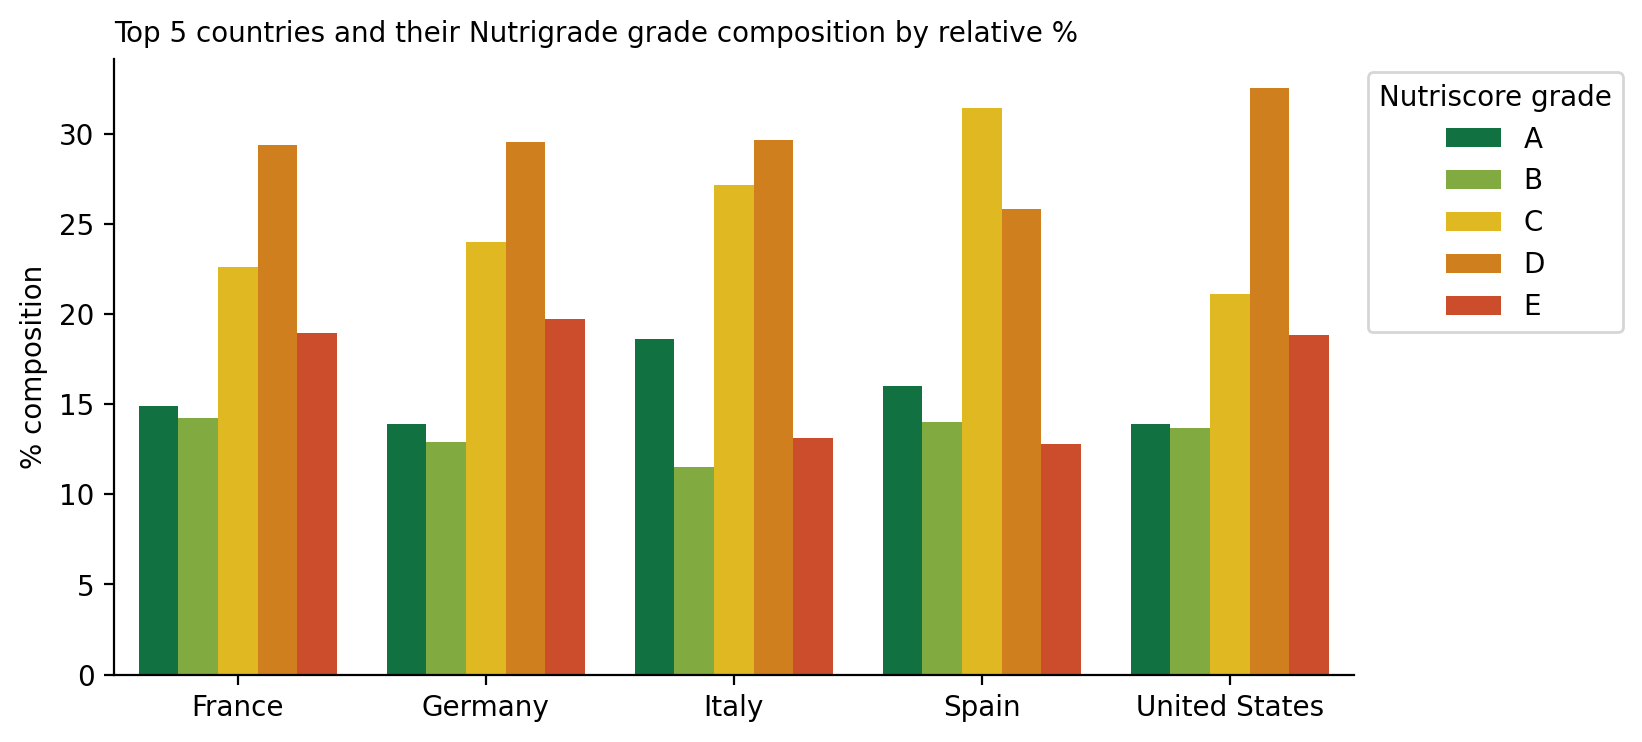

In [43]:
# Visualize the top 5 countries by Nutriscore grade composition in %
plt.figure(figsize=(8, 4))
sns.barplot(data=country_nutri_pc_melt, x="country", y="freq", hue="nutriscore_grade", palette=nutriscore_color)
plt.legend(title="Nutriscore grade", fontsize=10, bbox_to_anchor=(1,1))
plt.title("Top 5 countries and their Nutrigrade grade composition by relative %", loc="left", fontsize=10)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.xlabel("")
plt.ylabel("% composition")
plt.show()

In [44]:
# Examine NOVA group by Nutriscore grade
country_idx = full["countries_en"].value_counts()[0:15].index.values
nova_nutri = full[full["countries_en"].isin(country_idx)]

In [45]:
nova_nutri = pd.pivot_table(nova_nutri, index="nova_group", columns="nutriscore_grade", values="created_datetime", aggfunc="count").reset_index()

In [46]:
# Melt the dataframe for side by side bar plot
nova_nutri_melt = nova_nutri.melt(id_vars="nova_group", value_name="freq", var_name="nutriscore_score")
nova_nutri_melt["nutriscore_score"] = nova_nutri_melt["nutriscore_score"].apply(lambda x: x.upper())

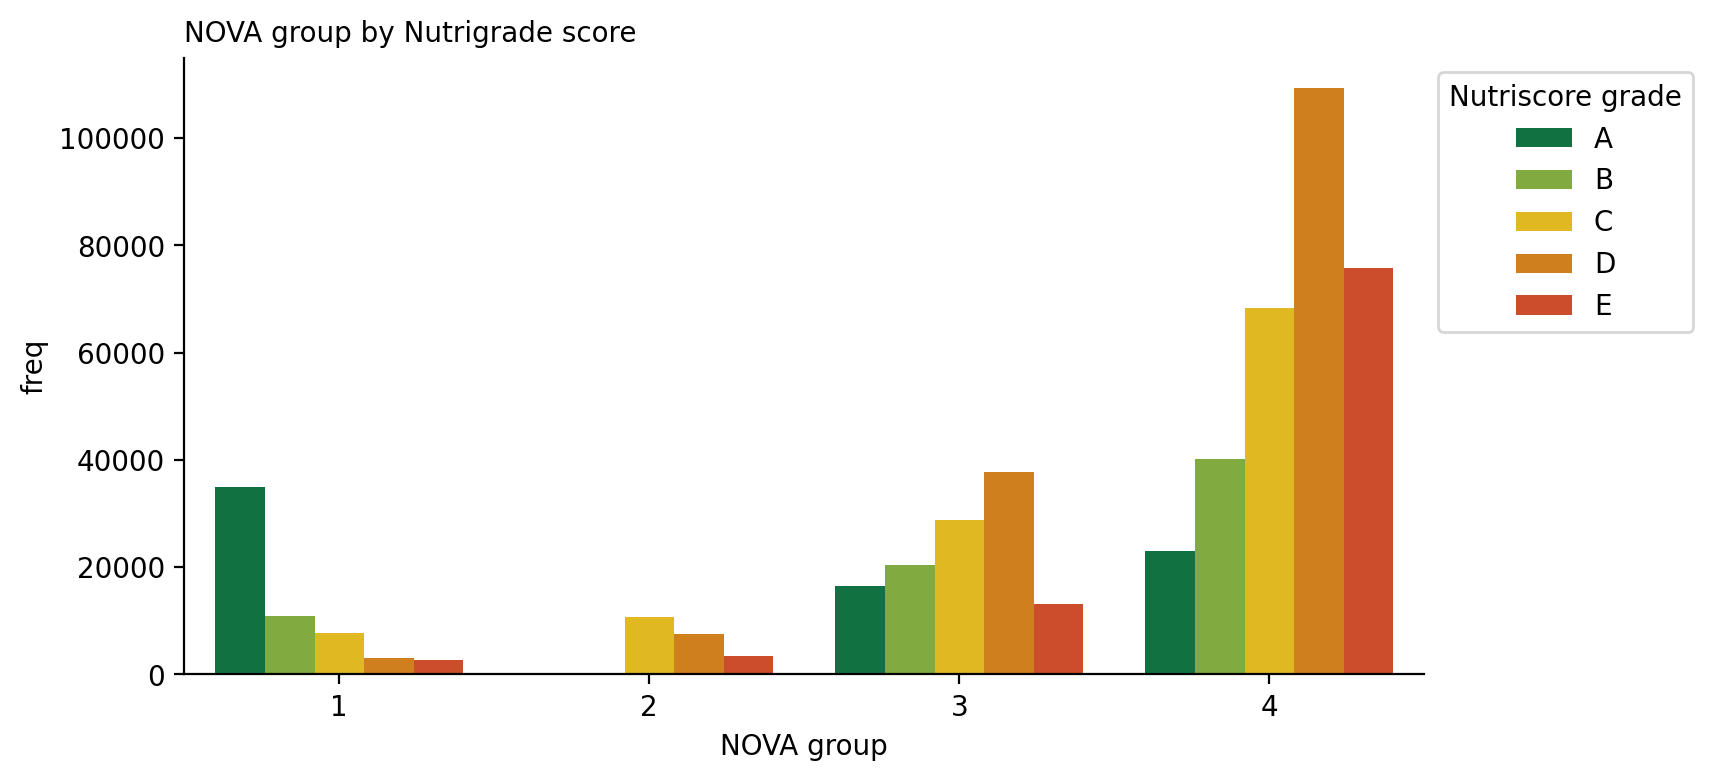

In [47]:
# Visualize NOVA groups by Nutriscore grade composition
plt.figure(figsize=(8, 4))
sns.barplot(data=nova_nutri_melt, x="nova_group", y="freq", hue="nutriscore_score", palette=nutriscore_color)
plt.legend(title="Nutriscore grade", fontsize=10, bbox_to_anchor=(1,1))
plt.title("NOVA group by Nutrigrade score", loc="left", fontsize=10)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.xlabel("NOVA group")
plt.show()

In [48]:
# Examine NOVA group by Nutriscore grade by % in NOVA group
country_idx = full["countries_en"].value_counts()[0:15].index.values
nova_nutri_pc = full[full["countries_en"].isin(country_idx)]

In [49]:
nova_nutri_pc = pd.pivot_table(nova_nutri_pc, index="nova_group", columns="nutriscore_grade", values="created_datetime", aggfunc="count", margins=True).reset_index()

In [50]:
for nutri_grade in ["a", "b", "c", "d", "e"]:
    nova_nutri_pc[nutri_grade] = nova_nutri_pc[nutri_grade] / nova_nutri_pc["All"] * 100
nova_nutri_pc = nova_nutri_pc.iloc[0:-1, 0: -1]

In [51]:
nova_nutri_pc_melt = nova_nutri_pc.melt(id_vars="nova_group", var_name="nutriscore_grade", value_name="freq")
nova_nutri_pc_melt["nutriscore_grade"] = nova_nutri_pc_melt["nutriscore_grade"].apply(lambda x: x.upper())

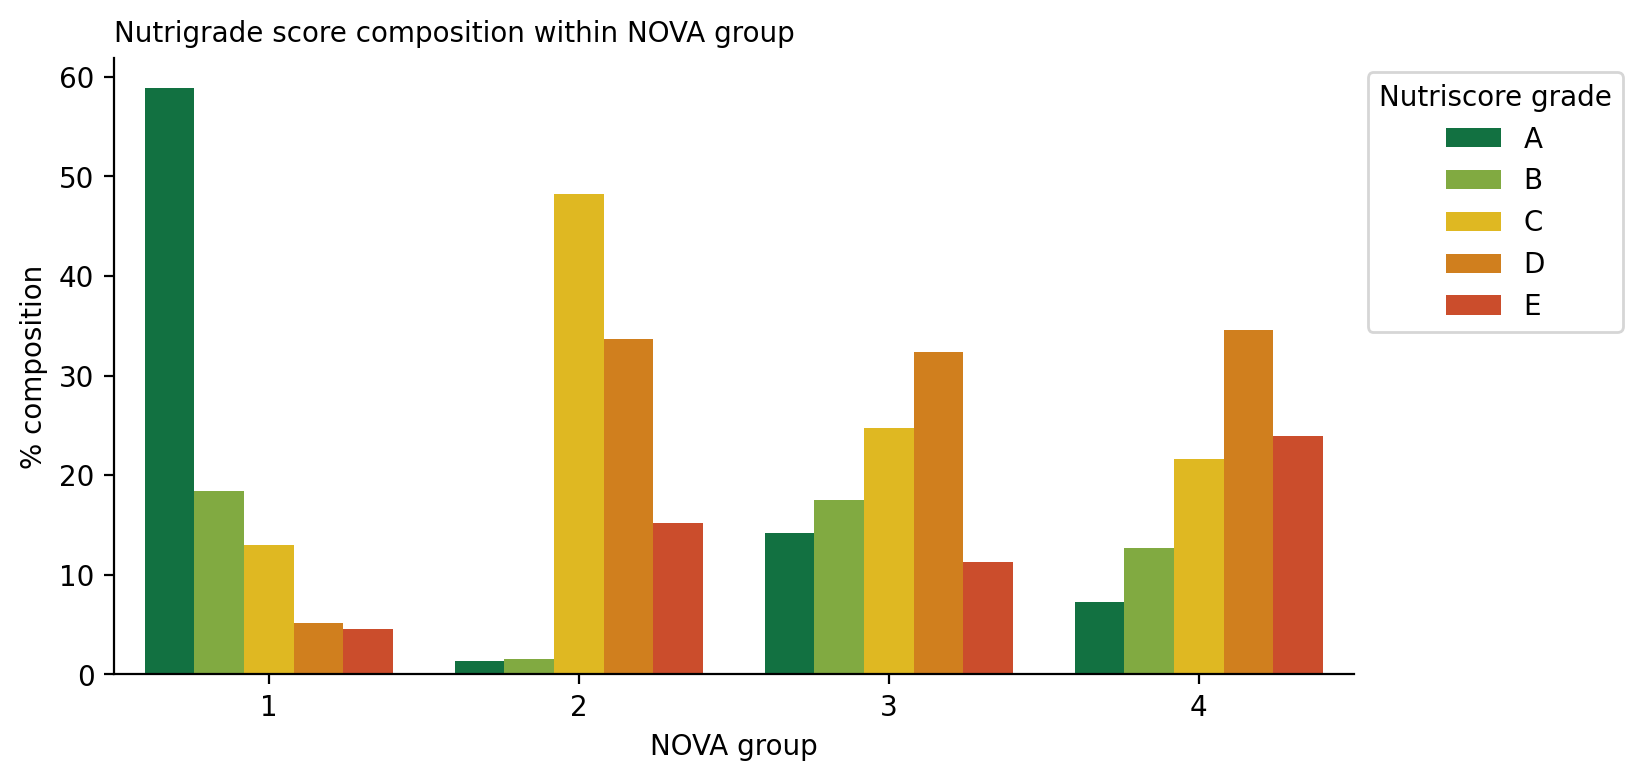

In [52]:
# Visualize NOVA groups by Nutriscore grade % composition
plt.figure(figsize=(8, 4))
sns.barplot(data=nova_nutri_pc_melt, x="nova_group", y="freq", hue="nutriscore_grade", palette=nutriscore_color)
plt.legend(title="Nutriscore grade", fontsize=10, bbox_to_anchor=(1,1))
plt.title("Nutrigrade score composition within NOVA group", loc="left", fontsize=10)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.xlabel("NOVA group")
plt.ylabel("% composition")
plt.show()

In [78]:
# Save the dataset from only top 15 countries
country_idx = full["countries_en"].value_counts()[0:15].index.values
full_15 = full[full["countries_en"].isin(country_idx)]

with open("full_data_nutri.pkl", "wb") as f:
    pickle.dump(full_15, f)
f.close()

### Downsample NOVA group samples - simple random selection

In [54]:
# Label composition by top 15 countries
nova.groupby("nova_group")["nova_group"].count()

nova_group
1     59233
2     22187
3    116627
4    316684
Name: nova_group, dtype: int64

In [71]:
# Random downsample based on population of nova group 2
class_size = 22_000
nova_1 = nova[nova["nova_group"] == "1"]
nova_2 = nova[nova["nova_group"] == "2"]
nova_3 = nova[nova["nova_group"] == "3"]
nova_4 = nova[nova["nova_group"] == "4"]

nova_1_sample = nova_1.sample(n=class_size, replace=False, random_state=42)
nova_2_sample = nova_2.sample(n=class_size, replace=False, random_state=42)
nova_3_sample = nova_3.sample(n=class_size, replace=False, random_state=42)
nova_4_sample = nova_4.sample(n=class_size, replace=False, random_state=42)

nova_sample = pd.concat([nova_1_sample, nova_2_sample, nova_3_sample, nova_4_sample], axis=0)
nova_sample = nova_sample.sample(frac=1) # Shuffle the downsampled dataset
nova_sample.reset_index(drop=True, inplace=True)

In [75]:
# Download the downsampled dataset (Dataset with no missing nutriscore or NOVA group data and top 15 countries)
with open("downsample_data_nutri.pkl", "wb") as f:
    pickle.dump(nova_sample, f)
f.close()

### Feature Engineering - Full dataset

Apply on dataset on top 15 countries with most data points

Feature engineer two groups of food product ingredient by one hot encoding manually: additives and ingredients. The dimension of these are too large, so PCA will be used to reduce the dimension of each feature.

In [2]:
# Load full data
with open("full_data_nutri.pkl", "rb") as f:
    dat = pickle.load(f)
f.close()

# Reset dataset index
dat.reset_index(drop=True, inplace=True)

In [3]:
# Determine the number of unique additive compounds in the dataset sample
dat.reset_index(drop=True, inplace=True)

additive = ",".join(dat["additives_tags"])
unq_additive = additive.split(",")
unq_additive = [s for s in unq_additive if len(s) > 0]

# Number of unique additives
unq_additive = set(unq_additive)
len(unq_additive)

513

In [4]:
# Check dimension of the dataset
dat.shape

(514731, 142)

In [5]:
# Keep only relevant variables for training
dat_additive = dat[["additives_tags"]]

In [6]:
# Create dataframe with columns only for unique additives
zero_array = np.zeros((dat_additive.shape[0], len(unq_additive)))
additive_df = pd.DataFrame(zero_array, columns=list(unq_additive))

In [7]:
dat_additive = pd.concat([dat_additive, additive_df], axis=1)

In [8]:
# Convert the additive values from string to list
dat_additive["additives_tags"] = dat_additive["additives_tags"].apply(lambda x: x.split(","))

# One hot encode the additive feature
for i, row in dat_additive.iterrows():
    print("Row", i, end="\r")
    if len(row[0]) > 1:
        for additive in row[0]:
            dat_additive.loc[i, additive] = 1

In [ ]:
dat_additive.shape

(514731, 514)

In [ ]:
additive_dim = dat_additive.drop("additives_tags", axis=1)

In [ ]:
# Apply PCA to reduce dimension on the additive feature
principal_additive = PCA(n_components=150)
principal_additive.fit(additive_dim)
x_additive = principal_additive.transform(additive_dim)

In [ ]:
sum(principal_additive.explained_variance_ratio_)

0.9716158545850846

In [ ]:
# Visualize principal component explained variance contribution
cum_variance_ratio = np.cumsum(principal_additive.explained_variance_ratio_)

for i in range(len(cum_variance_ratio)):
    if cum_variance_ratio[i] >= 0.95:
        print(f"PC with cumulative variance ratio >= 95%: {i}")
        break

PC with cumulative variance ratio >= 95%: 120


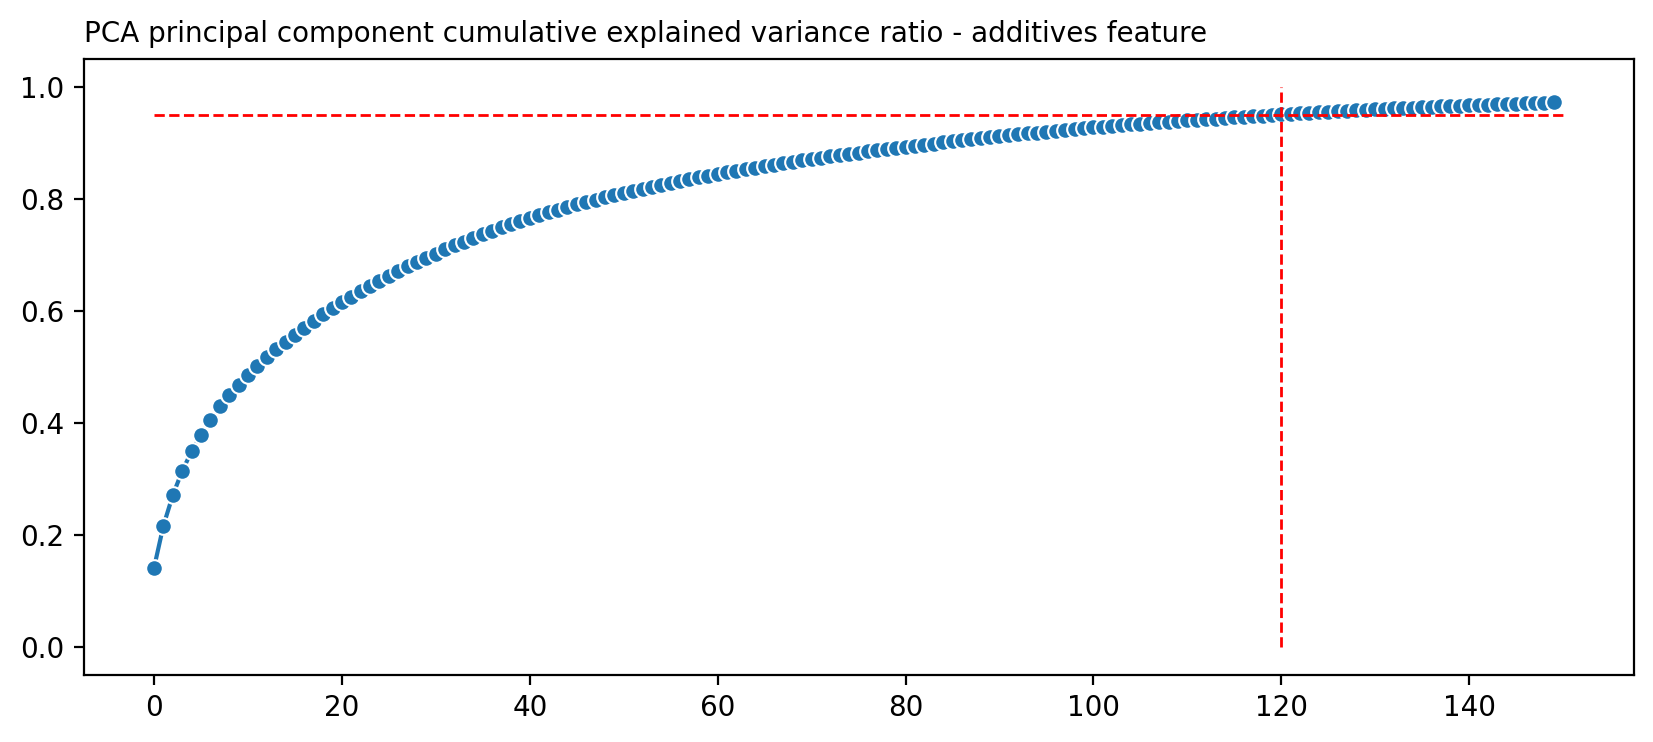

In [ ]:
plt.figure(figsize=(10, 4))
sns.lineplot(y=cum_variance_ratio, x=np.arange(0, len(cum_variance_ratio)), marker="o")
plt.hlines(0.95, xmin=0, xmax=len(cum_variance_ratio), color="red", linewidth=1, linestyle="--")
plt.vlines(120, ymin=0, ymax=1, color="red", linewidth=1, linestyles="--")
plt.title("PCA principal component cumulative explained variance ratio - additives feature", fontsize=10, loc="left")
plt.show()

In [ ]:
# Dimension of additive feature after applying PCA
x_additive.shape

(514731, 150)

In [ ]:
# Apply PCA to reduce dimension on the additive feature to 120 components
principal_additive = PCA(n_components=120)
principal_additive.fit(additive_dim)
x_additive = principal_additive.transform(additive_dim)
sum(principal_additive.explained_variance_ratio_)

0.9489054802082368

In [ ]:
x_additive.shape

(514731, 120)

In [97]:
# Convert feature into a dataframe for subsequent model training
col_names = ["f" + str(i) for i in range(1, 121)]
x_additive = pd.DataFrame(data=x_additive, columns=col_names)

In [98]:
# Download the reduced additive component
with open("full_additive_feature.pkl", "wb") as f:
    pickle.dump(x_additive, f)
f.close()

⬆️ Dimension of the additive feature reduced from 512 to 120 after applying PCA

In [99]:
with open("full_data_nutri.pkl", "rb") as f:
    dat = pickle.load(f)
f.close()

In [100]:
# Determine the number of unique ingredients compounds in the dataset sample
# country_idx = full["countries_en"].value_counts()[0:15].index.values
# dat = full[full["countries_en"].isin(country_idx)].copy()
# dat.reset_index(drop=True, inplace=True)

ingredients = ",".join(dat["ingredients_tags"])
unq_ingredients = ingredients.split(",")
unq_ingredients = [s for s in unq_ingredients if len(s) > 0]

# Number of unique ingredients
unq_ingredients = set(unq_ingredients)
len(unq_ingredients)

356210

### Feature Engineering - Downsampled dataset

Apply on dataset on top 15 countries with most data points

In [160]:
with open("downsample_data_nutri.pkl", "rb") as f:
    down_dat = pickle.load(f)
f.close()

In [161]:
# Determine the number of unique additive compounds in the dataset sample
down_dat.reset_index(drop=True, inplace=True)

additive = ",".join(down_dat["additives_tags"])
unq_additive = additive.split(",")
unq_additive = [s for s in unq_additive if len(s) > 0]

# Number of unique additives
unq_additive = set(unq_additive)
len(unq_additive)

377

In [162]:
# Check dimension of the dataset
down_dat.shape

(88000, 142)

In [164]:
# Keep only relevant variables for training
down_dat_additive = down_dat[["additives_tags"]]

In [165]:
# Create dataframe with columns only for unique additives
zero_array = np.zeros((down_dat_additive.shape[0], len(unq_additive)))
down_additive_df = pd.DataFrame(zero_array, columns=list(unq_additive))

In [166]:
down_dat_additive = pd.concat([down_dat_additive, down_additive_df], axis=1)

In [167]:
# Convert the additive values from string to list
down_dat_additive["additives_tags"] = down_dat_additive["additives_tags"].apply(lambda x: x.split(","))

# One hot encode the additive feature
for i, row in down_dat_additive.iterrows():
    print("Row", i, end="\r")
    if len(row[0]) > 1:
        for additive in row[0]:
            down_dat_additive.loc[i, additive] = 1

In [168]:
down_dat_additive.shape

(88000, 378)

In [170]:
down_additive_dim = down_dat_additive.drop("additives_tags", axis=1)

In [177]:
# Apply PCA to reduce dimension on the additive feature
principal_down_additive = PCA(n_components=150)
principal_down_additive.fit(down_additive_dim)
x_down_additive = principal_down_additive.transform(down_additive_dim)

In [172]:
sum(principal_down_additive.explained_variance_ratio_)

0.9734590837644157

In [173]:
# Visualize principal component explained variance contribution
cum_variance_ratio = np.cumsum(principal_down_additive.explained_variance_ratio_)

for i in range(len(cum_variance_ratio)):
    if cum_variance_ratio[i] >= 0.95:
        print(f"PC with cumulative variance ratio >= 95%: {i}")
        break

PC with cumulative variance ratio >= 95%: 117


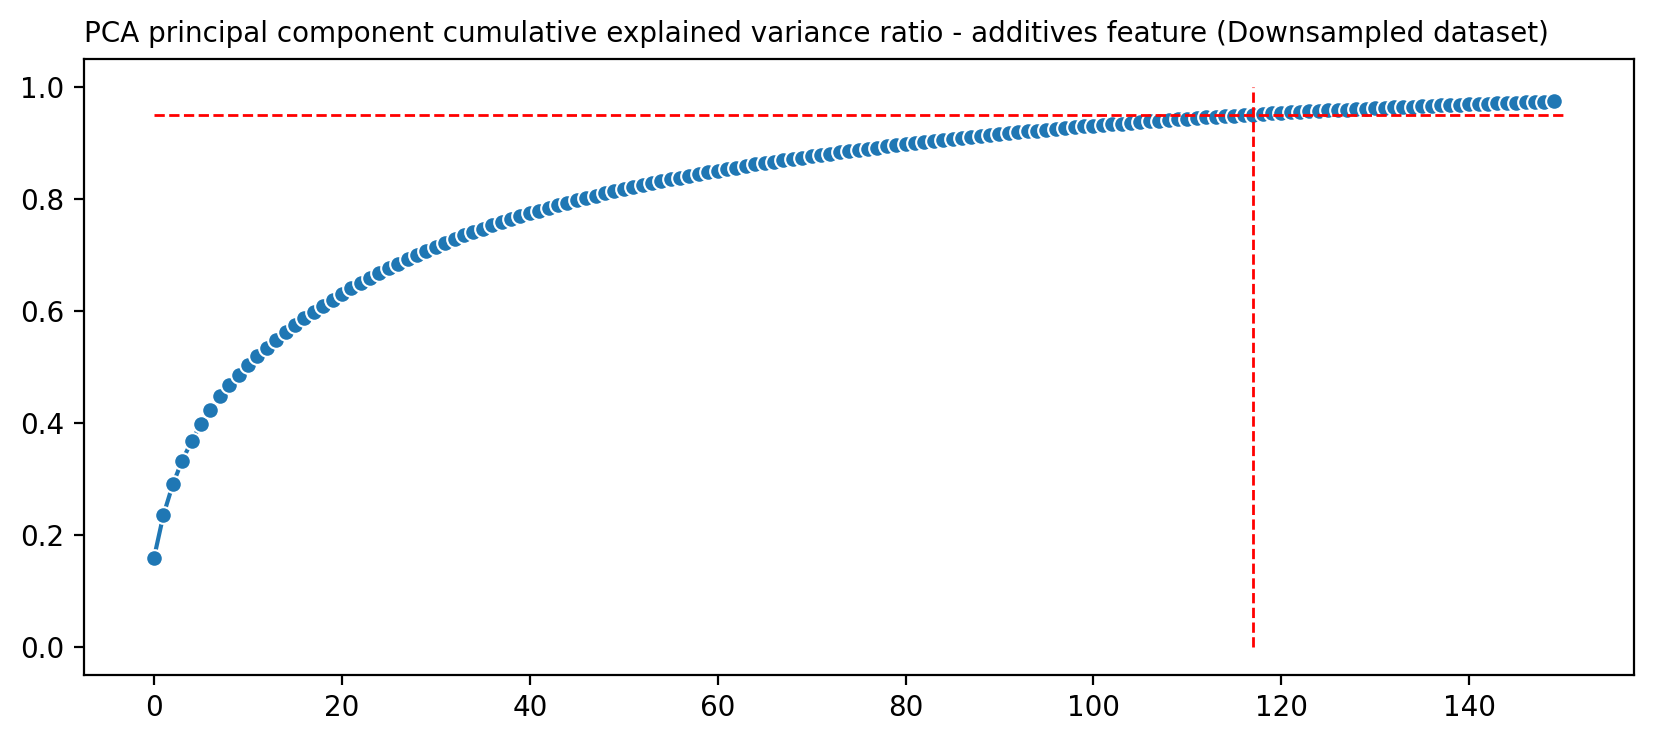

In [174]:
plt.figure(figsize=(10, 4))
sns.lineplot(y=cum_variance_ratio, x=np.arange(0, len(cum_variance_ratio)), marker="o")
plt.hlines(0.95, xmin=0, xmax=len(cum_variance_ratio), color="red", linewidth=1, linestyle="--")
plt.vlines(117, ymin=0, ymax=1, color="red", linewidth=1, linestyles="--")
plt.title("PCA principal component cumulative explained variance ratio - additives feature (Downsampled dataset)", fontsize=10, loc="left")
plt.show()

In [175]:
x_down_additive.shape

(88000, 150)

In [181]:
# Apply PCA to reduce dimension on the additive feature to 117 components
principal_down_additive = PCA(n_components=117)
principal_down_additive.fit(down_additive_dim)
x_down_additive = principal_down_additive.transform(down_additive_dim)
sum(principal_down_additive.explained_variance_ratio_)

0.9486871813570347

In [182]:
x_down_additive.shape

(88000, 117)

In [184]:
# Convert feature into a dataframe for subsequent model training
col_names = ["f" + str(i) for i in range(1, 118)]
x_down_additive = pd.DataFrame(data=x_down_additive, columns=col_names)

In [188]:
# Download the reduced additive component
with open("downsample_additive_feature.pkl", "wb") as f:
    pickle.dump(x_down_additive, f)
f.close()

: 

In [ ]:
principal_additive